In [127]:
# install your library

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
import random

In [128]:
path = "C:/Users/zjy97/Downloads/python-causality-handbook-v1.0/matheusfacure-python-causality-handbook-f666303/causal-inference-for-the-brave-and-true/data/"

In [107]:
# 1. good controls
# not always having all variables lead to good result
data = pd.read_csv(path+'collections_email.csv')
# for example, if we randomize a new column that means email sending, randomly picking some customers to send emails
model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]# coef=ATE=-0.62 but p is very high that means treatment to both groups is not statistically significant

# so that means we need to control features related to treatment and outcome, not randomized variables

# let's control some related columns like outcome, payments, creadict limit and risk score
# this whole process lowers the variables of the dependent variable
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()# lower the variance of the dependent credict limit and risk score
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()# lower the variance of dependent variable credict limit and risk score

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()
model_treatment.summary().tables[1]# p == 0.038, very significant, 


# right now, you know how adding confoudings into your model works for regression, now just do what we regular do
model_2 = smf.ols('payments ~ email+credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1] # 4.4 and p value said your experiment is significant

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [112]:
# 2. mostly harmful controls

# let's perform another experiment, say if treatment is effective, lower days of being in hospital
hospital = pd.read_csv(path+'hospital_treatment.csv')
# first instinct is simply running a regression because you already randomized your data, assume there are no confoundings
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]# this is counterintitive thing. treatment increases days of hospitality? because there are confounders like severity

# you can do grouping for each confounder, but the best way is to do regression, considering all confounders

hosp_2 = smf.ols('days ~ treatment+severity+hospital', data=hospital).fit()
hosp_2.summary().tables[1]# surprisingly, it can hurt because p value of hospital is very high, it's not related! so we should drop


# to find bad controls, you can pick all variale, and onns that have big p value should be those bad controlls

# 3. selection bias
# when you use some features to predict the outcome variable, the feature A and feature B are caused by feature C, that means in your
# features, there is a collider, this makdes selection bias!
# so when picking features, you should pick confounders, or pick features related to outcome variable but not related to
# dependent variable. Two bad picking are a. pick two features that construct collider with your treatment
# b. pick one that is not related to outcome variable but related to your treatment, if there is no related confounders between treatment and outcome variable



# 4. what is instrumental variables
# if we cannot have the good confounder to control, we can use variables that related to treatment but not related to the outcome
# please be careful to use instrumental variables, pay attention on if there is no confounders, we should not use instrumental vars


# 5. test instrumental variable

# case
data = pd.read_csv(path+'ak91.csv')
# we would use quarter of birth as an instrument, but we need to test if it is instrumental
# first to test if the instrument indeed impacts the treatment variable, meaning that Cov(Z,T) not equal to 0

group_data = (data
             .groupby(['year_of_birth', 'quarter_of_birth'])
             [['log_wage','years_of_schooling']]
             .mean()
             .reset_index()
             .assign(time_of_birth = lambda d:d['year_of_birth'] + (d['quarter_of_birth'])/4))

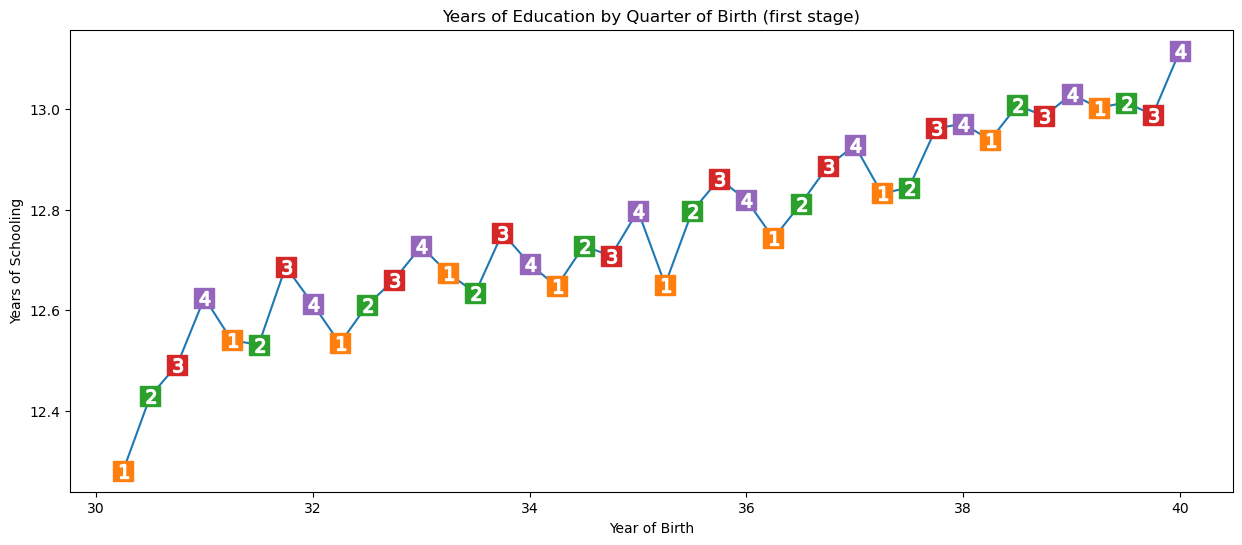

In [113]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

In [116]:
# from the plot, we can see that people that were born in later quarter has more education
# but let's do a more rigorous analysis, to convert the quarter of birth to dummy variable and run a regression on q4 and year_of_schooling
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

first_stage = smf.ols('years_of_schooling ~ C(year_of_birth)+C(state_of_birth)+q4', data=factor_data).fit()
first_stage.pvalues['q4']

5.464829416624155e-15

In [117]:
first_stage.params['q4']# on this small p value, we can think guys born in q4 have more eduction years, 0.1 more

0.10085809272786456

In [118]:
# 6. second test for instrumental variable
# we should test this instrumental variable to know whether it is not related to the outcome variable

# however, we cannot test it, why??? because of exclusive restriction, there must be correlation between the instrument and outcome
# but it doesnt mean there are direct impact, that could be indirect impact, and indirect impact could be from treatment
# so we never can test this!

# 7. run your experiment with your IV instrumental variables

# reduced form targets to figure out how the instrument influences the outcome
reduced_form = smf.ols('log_wage ~ C(year_of_birth) + C(state_of_birth) + q4', data = factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])
# the result is significant, on average we have 0.8% higher wage

q4 parameter estimate:,  0.008603484260138822
q4 p-value:,  0.0014949127183683671


In [120]:
# 8. get your IV

# 8.1 First method, use scaling, scale out the impact from treatment
# now, we got both reduced form and our 1st stage, we can scale the effect of the first stage by the reduced form
# the coef from first stage is 0.1, it will multiply the effect of the reduced form coefficient by almost 10

# so right now, scaled ATE is reduced form/1st stage = 
reduced_form.params["q4"] / first_stage.params["q4"]# we should expect each additional year of school to increase wages by 8%


# 8.2 Second method, use 2 stages least squares
# the 1 stage is the same, but the 2 stage we replace the treatment variable by the fitted value of the 1st stage
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]# the parameter is exactly same, 0.08

# in python, it has function to do 2sls for us

0.08530286492089889

In [125]:
def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")

from linearmodels.iv import IV2SLS
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.08530286492577943
SE: 0.02554081281367496
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914654398415


In [132]:
iv2sls.params['years_of_schooling']

0.08530286492577943

In [ ]:
# 9. what is a good IV

# a. good IV has a strong stage 1 and if stage 1 is strong the second stage will also be strong
# b. but if we have a weak first stage, that means instrument has only a very small correlation with treatment, then we could not
# learn much more about the treatment from the instrument
# c. good IV means the first stage has good correlation, that leads to smaller standard error and smaller CI as well


In [133]:
# 10. let's run multiple instruments using 2SLS
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)
# we have 3 dummies here, and the ATE is 0.1 for every addition year of education it is 10% average increase
# 2SLS's CI is wider than OLS

Parameter: 0.10769370489424546
SE: 0.019557149009539386
95 CI: [0.06936169 0.14602572]
P-value: 3.657974678716869e-08


In [ ]:
# 11. 2SLS is biased
# even with high correlation, the parameter estimate still doesnt reach the true ATE, and maybe not even in the 95% CI
# 2SLS is only consistent that means it approaches the true parameter value if the sample size is big enough, but cannot know 
# how big is big enough

# a. 2SLS is biased towards OLS, if OLS has a negative/positive bias, 2SLS will also have it
# b. 2SLS is at least consistent, but OLS not.
# c. If Unmeasureable has nagtive(positive) impact on treatment but positive(negative) on outcome, it will have positive bias.
# d. the bias will increase once the number of instruments we add. If we add too many instruments, 2SLS

In [ ]:
# 12. some common mistakes when doing IV

# dont do IV, doing it by software, cause it causes wrong standard errors
# dont replace the 1st stage OLS with logistic regression although the prediction is on a dummy variable.
# The consistency of IV relies on a property that only OLS can give, which is the orthogonality of the residuals.
# orthogonality means the sum of the product of residuals and predicted values is zero, 
# or the residual(difference between predicted and outcome vairable) and predicted value are orthogonal
